In [1]:
!pip install ultralytics insightface onnxruntime-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s 

In [6]:
import os
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.nn as nn
from ultralytics import YOLO
from insightface.app import FaceAnalysis
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

In [21]:
YOLO_WEIGHTS = "./scbyolov8.pt"        # model yolo predict behavior with handwise read write
EMO_WEIGHTS  = "./fer_resnet18.ckpt"   # model train fer 2013 for emotion
TARGET_BEHAVIORS = {"hand-raising", "read", "write"}

In [22]:
# Load YOLO model
model_yolo = YOLO(YOLO_WEIGHTS)
# Try to get class names from the model
try:
    yolo_names = model_yolo.names
    # In some exports this is a list not dict
    if isinstance(yolo_names, list):
        yolo_names = {i:n for i,n in enumerate(yolo_names)}
except Exception:
    yolo_names = {}

print("YOLO classes:", yolo_names)

YOLO classes: {0: 'hand-raising', 1: 'read', 2: 'write'}


## test Yolo model

In [29]:
result_yolos = model_yolo.predict(
    source='./images',
    conf=0.3,
    save=True
)

Results saved to runs/detect/predict


In [33]:
yolo_result_dir = result_yolos[0].save_dir
print("Results saved in:", yolo_result_dir)

Results saved in: runs/detect/predict


## save result predict to csv file

In [35]:
import pandas as pd

df_all = []

for r in result_yolos:
    img_path = r.path
    for box in r.boxes.data.cpu().numpy():
        x1, y1, x2, y2, conf, cls = box
        df_all.append({
            "image": img_path,
            "class_id": int(cls),
            "confidence": round(float(conf), 2),
            "bbox": [round(x1,2), round(y1,2), round(x2,2), round(y2,2)]
        })

pd.DataFrame(df_all).to_csv("test_predictions.csv", index=False)

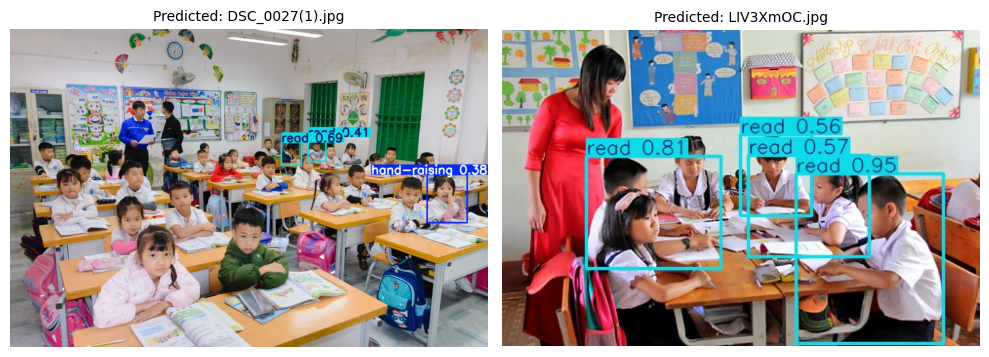

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, math

image_files = [f for f in os.listdir(yolo_result_dir) if f.endswith(".jpg")]

cols = 2
rows = math.ceil(len(image_files) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for i, image_file in enumerate(image_files):
    img_path = os.path.join(yolo_result_dir, image_file)
    img = mpimg.imread(img_path)

    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {image_file}", fontsize=10)
    axes[i].axis('off')

# Hide unused subplots
for j in range(len(image_files), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Load InsightFace face detector (will auto-download its retinaface/antelope models)
providers = ["CUDAExecutionProvider", "CPUExecutionProvider"]
fa = FaceAnalysis(name="buffalo_l")  # robust default
fa.prepare(ctx_id=0 if torch.cuda.is_available() else -1, det_size=(640, 640))

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 102770.86KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

## Load Fer model

In [16]:
ckpt = torch.load("./fer_resnet18.ckpt", map_location="cpu")
fer_class_names = ckpt["class_names"];
IMG_SIZE = ckpt["img_size"]
fer_class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [17]:
from torchvision import datasets, transforms, models

fer_transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std= [0.229,0.224,0.225]),
])

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(fer_class_names))
model.load_state_dict(ckpt["model"])
model.eval()

def predict(img_path):
    img = Image.open(img_path).convert("L")
    x = fer_transform(img).unsqueeze(0)
    with torch.no_grad():
        logits = model(x)
        prob = torch.softmax(logits, dim=1).squeeze(0)
    cls_id = int(prob.argmax().item())
    return fer_class_names[cls_id], float(prob[cls_id])

## Utility helpers

In [56]:
def safe_mkdir(p):
    Path(p).mkdir(exist_ok=True, parents=True)

def imread(path):
    img = cv2.imread(str(path))
    if img is None:
        raise RuntimeError(f"Failed to read image: {path}")
    return img

def save_image(path, img):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(path), img)

def clip_box(xyxy, w, h):
    x1, y1, x2, y2 = [int(v) for v in xyxy]
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2 <= x1: x2 = min(w-1, x1+1)
    if y2 <= y1: y2 = min(h-1, y1+1)
    return x1, y1, x2, y2

# ========= UTILS =========
def clamp_box(x1, y1, x2, y2, w, h, pad=0):
    x1 = max(0, int(x1 - pad)); y1 = max(0, int(y1 - pad))
    x2 = min(w-1, int(x2 + pad)); y2 = min(h-1, int(y2 + pad))
    return x1, y1, x2, y2

## Run the pipeline on images

In [44]:
BEHAVIOR_OUT_DIR = "./behavior_crops"
os.makedirs(BEHAVIOR_OUT_DIR, exist_ok=True)


# --- 1. Load models ---
# YOLOv8 for behavior detection
model_yolo = YOLO(YOLO_WEIGHTS)


# 2. InsightFace for face detection/embedding
face_app = FaceAnalysis(name='buffalo_l')
face_app.prepare(ctx_id=0, det_size=(224, 224))


# 3. FER ResNet18 model
ckpt = torch.load("./fer_resnet18.ckpt", map_location="cpu")
fer_class_names = ckpt["class_names"];
IMG_SIZE = ckpt["img_size"]
fer_model = models.resnet18(weights=None)
fer_model.fc = nn.Linear(model.fc.in_features, len(fer_class_names))
fer_model.load_state_dict(ckpt["model"])
fer_model.eval()

fer_transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std= [0.229,0.224,0.225]),
])


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

In [63]:
# --- 4. Run YOLO behavior detection ---
INPUT_IMG = "./images/LIV3XmOC.jpg"
result_yolos = model_yolo.predict(
    source=INPUT_IMG
)


croppeds = []
img_bgr = cv2.imread(INPUT_IMG)

for r in result_yolos:
    img_bgr = cv2.imread(INPUT_IMG)
    for i, box in enumerate(r.boxes.xyxy):
      x1, y1, x2, y2 = map(int, box)
      crop = img_bgr[y1:y2, x1:x2]
      # Get the image name without extension
      img_name = os.path.splitext(os.path.basename(INPUT_IMG))[0]

      #crop_path = os.path.join(BEHAVIOR_OUT_DIR, f"behavior_{i}.jpg")
      crop_path = os.path.join(BEHAVIOR_OUT_DIR, f"{img_name}_{i}.jpg")
      cv2.imwrite(crop_path, crop)
      croppeds.append({
          "path": crop_path,
          "behavior": r.names[int(r.boxes.cls[i])],
          "confidence": round(float(r.boxes.conf[i]), 2),
          "bbox": [x1, y1, x2, y2],
          "filename": f"{img_name}_{i}.jpg"
      })
croppeds


image 1/1 /content/images/LIV3XmOC.jpg: 448x640 4 reads, 49.8ms
Speed: 2.6ms preprocess, 49.8ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


[{'path': './behavior_crops/LIV3XmOC_0.jpg',
  'behavior': 'read',
  'confidence': 0.95,
  'bbox': [301, 148, 452, 322],
  'filename': 'LIV3XmOC_0.jpg'},
 {'path': './behavior_crops/LIV3XmOC_1.jpg',
  'behavior': 'read',
  'confidence': 0.81,
  'bbox': [86, 130, 224, 245],
  'filename': 'LIV3XmOC_1.jpg'},
 {'path': './behavior_crops/LIV3XmOC_2.jpg',
  'behavior': 'read',
  'confidence': 0.57,
  'bbox': [252, 129, 376, 233],
  'filename': 'LIV3XmOC_2.jpg'},
 {'path': './behavior_crops/LIV3XmOC_3.jpg',
  'behavior': 'read',
  'confidence': 0.56,
  'bbox': [244, 108, 317, 191],
  'filename': 'LIV3XmOC_3.jpg'}]

In [64]:
for crop in croppeds:
    path = crop["path"]
    img = cv2.imread(path)
    faces = face_app.get(img)
    for f in faces:
        x1, y1, x2, y2 = map(int, f.bbox)
        face_crop = img[y1:y2, x1:x2]

        if face_crop is not None and face_crop.size > 0:
            face_pil = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
            face_tensor = fer_transform(Image.fromarray(face_pil)).unsqueeze(0)
            with torch.no_grad():
                pred = fer_model(face_tensor)
                emotion = fer_class_names[pred.argmax().item()]

            print(f"{path} → Emotion: {emotion}")
        else:
            print(f"Warning: Empty face crop detected for {path}. Skipping emotion prediction for this face.")

./behavior_crops/LIV3XmOC_0.jpg → Emotion: sad
./behavior_crops/LIV3XmOC_1.jpg → Emotion: fear
./behavior_crops/LIV3XmOC_1.jpg → Emotion: sad
./behavior_crops/LIV3XmOC_2.jpg → Emotion: angry
./behavior_crops/LIV3XmOC_3.jpg → Emotion: angry


 LIV3XmOC_0.jpg | read. angry (0.888) @ (16, 0, 40, 30)
 LIV3XmOC_0.jpg | read. sad (0.560) @ (63, 25, 93, 63)
 LIV3XmOC_1.jpg | read. neutral (0.654) @ (96, 0, 121, 22)
 LIV3XmOC_1.jpg | read. fear (0.959) @ (46, 47, 76, 88)
 LIV3XmOC_1.jpg | read. sad (1.000) @ (38, 18, 63, 53)
 LIV3XmOC_2.jpg | read. angry (0.812) @ (65, 17, 88, 49)
 LIV3XmOC_2.jpg | read. angry (0.931) @ (13, 0, 37, 22)
 LIV3XmOC_3.jpg | read. angry (0.671) @ (21, 17, 44, 43)


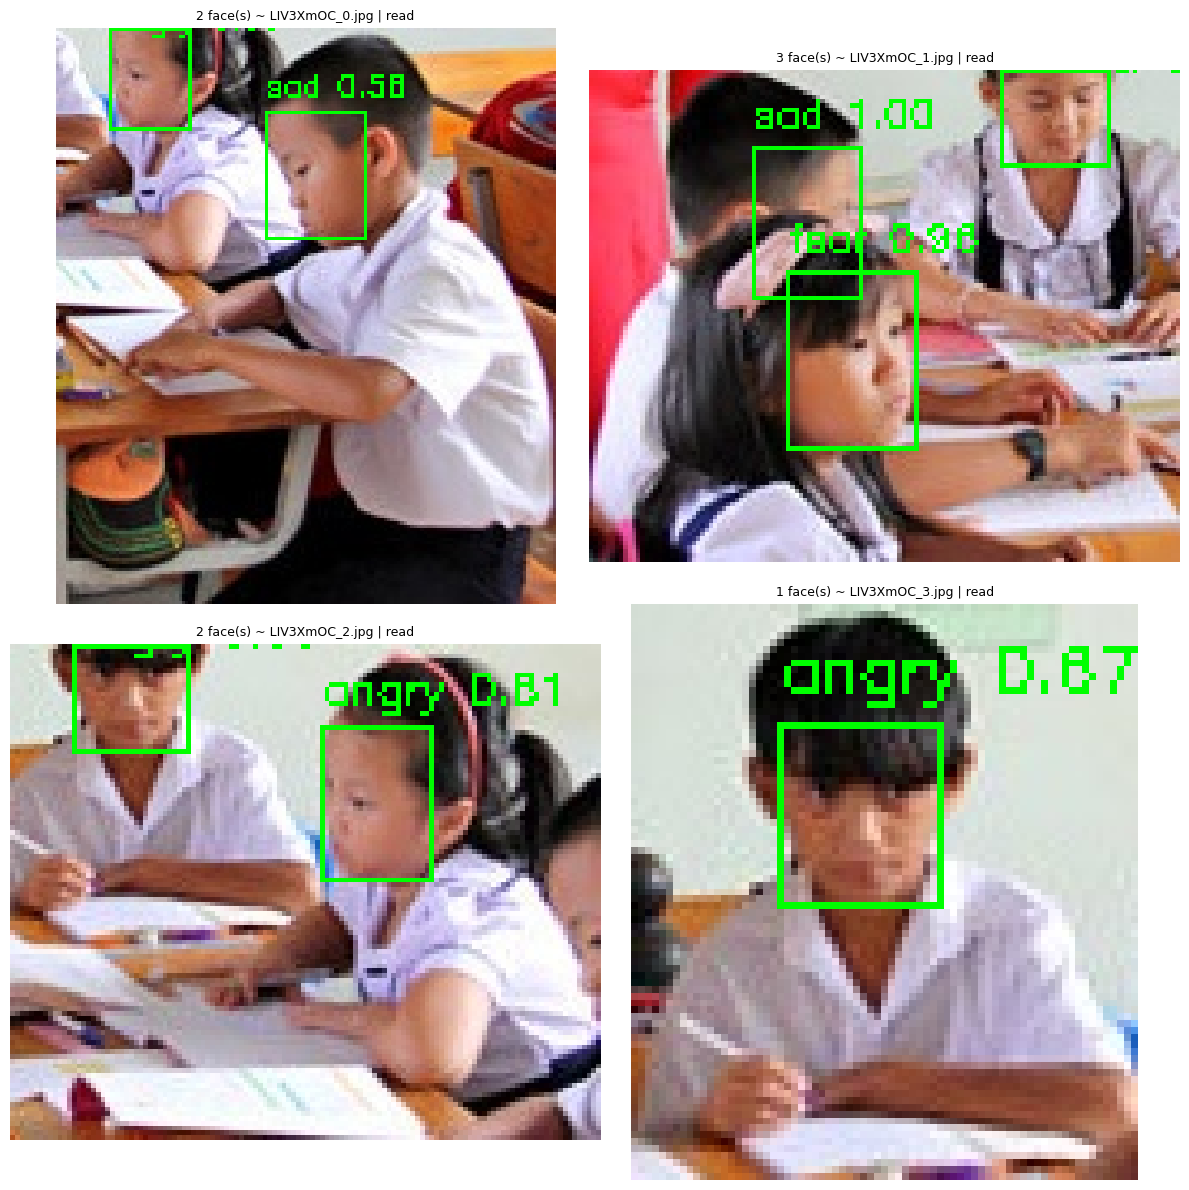

In [77]:
# --- 5. Show all cropped behavior images
@torch.no_grad()
def predict_face_crop(pil_img):
    x = fer_transform(pil_img).unsqueeze(0)
    logits = model(x)
    prob = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
    cls_id = int(np.argmax(prob))
    return fer_class_names[cls_id], float(prob[cls_id])



cols = 2
rows = math.ceil(len(croppeds) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
axes = axes.flatten()

for idx, crop in enumerate(croppeds):
    path = crop["path"]
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        continue

    faces = face_app.get(img_bgr)
    h, w = img_bgr.shape[:2]
    img_draw = img_bgr.copy()
    results = []

    for f in faces:
        x1, y1, x2, y2 = f.bbox.astype(int)
        x1, y1, x2, y2 = clamp_box(x1, y1, x2, y2, w, h, pad=0)
        crop_bgr = img_bgr[y1:y2, x1:x2]
        crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
        pil_crop = Image.fromarray(crop_rgb).convert("L")
        label, conf = predict_face_crop(pil_crop)
        results.append(((x1, y1, x2, y2), label, conf))
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), (0, 255, 0), 1)
        # Reduce the font scale for smaller text
        cv2.putText(img_draw, f"{label} {conf:.2f}", (x1, max(y1-5, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

    img_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
    axes[idx].imshow(img_rgb)
    axes[idx].axis("off")
    axes[idx].set_title(f"{len(results)} face(s) ~ {crop['filename']} | {crop['behavior']}", fontsize=9)
    # Print results in console
    for i, (box, label, conf) in enumerate(results, 1):
        print(f" {crop['filename']} | {crop['behavior']}. {label} ({conf:.3f}) @ {box}")

# Hide unused axes if any
for j in range(len(croppeds), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()